# LIT-PCBA 
this dataset is a proposed "more difficult" test than DUD-E. I used a 75/25 (sklearn default) stratified split. The dataset is heavily imbalanced, like DUD-E.

In [1]:
import pickle
from sklearn.metrics import roc_auc_score
import numpy as np
import seaborn as sns
import torch
import seaborn as sns
import pandas as pd
from pathlib import Path
from sklearn.metrics import f1_score, recall_score
import matplotlib.pyplot as plt

plt.rc('font', family='serif')
plt.rc('xtick', labelsize='large')
plt.rc('ytick', labelsize='large')
plt.rc('text', usetex=True)

In [2]:
def compute_enrichment_factor(scores, labels, n_percent):
    # this variant implements the equation from Xiaohua's paper
#     import pdb
#     pdb.set_trace()
    
    sample_n = int(np.ceil(n_percent * labels.shape[0]))
    
    
    
    sorted_scores = sorted(zip(scores, labels), key=lambda x: x[0], reverse=True)

    top_n_sorted_scores = sorted_scores[:sample_n]

    # counting number of true positives in top x% of sorted compounds
    actives_sampled = sum([y for x, y in top_n_sorted_scores])
    # labels are binary, sum to count number of actives
    actives_database = sum(labels)

    norm_factor = (sample_n/len(labels))

    return (actives_sampled / actives_database) * (labels.shape[0]/sample_n)


In [3]:
data_p = Path("/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results")

In [4]:
lit_pcba_path_list = [x for x in list(data_p.glob("lit_pcba_*_random_strat_split.*.pkl")) if "lit_pcba_ave" not in x.parent.parent.name]
lit_pcba_path_list 

[PosixPath('/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba_ADRB2_random_strat_split.ecfp.pkl'),
 PosixPath('/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba_ALDH1_random_strat_split.ecfp.pkl'),
 PosixPath('/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba_ESR1_ago_random_strat_split.ecfp.pkl'),
 PosixPath('/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba_ESR1_ant_random_strat_split.ecfp.pkl'),
 PosixPath('/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba_FEN1_random_strat_split.ecfp.pkl'),
 PosixPath('/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba_GBA_random_strat_split.ecfp.pkl'),
 PosixPath('/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba_IDH1_random_strat_split.ecfp.pkl'),
 PosixPath('/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba_KAT2A_random_strat_split.ecfp.pkl'),
 PosixPath('/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy

In [5]:
import re

lit_pcba_target_names = ["_".join(re.sub("_split.*.pkl", "", x.name.replace("lit_pcba_", "").replace("random_strat", "")).split("_")[:-1]) for x in lit_pcba_path_list]
lit_pcba_target_names

['ADRB2',
 'ALDH1',
 'ESR1_ago',
 'ESR1_ant',
 'FEN1',
 'GBA',
 'IDH1',
 'KAT2A',
 'MAPK1',
 'MTORC1',
 'OPRK1',
 'PKM2',
 'PPARG',
 'TP53',
 'VDR',
 'ADRB2',
 'ALDH1',
 'ESR1_ago',
 'ESR1_ant',
 'FEN1',
 'GBA',
 'IDH1',
 'KAT2A',
 'MAPK1',
 'MTORC1',
 'OPRK1',
 'PKM2',
 'PPARG',
 'TP53',
 'VDR',
 'ADRB2',
 'ALDH1',
 'ESR1_ago',
 'ESR1_ant',
 'FEN1',
 'GBA',
 'IDH1',
 'KAT2A',
 'MAPK1',
 'MTORC1',
 'OPRK1',
 'PKM2',
 'PPARG',
 'TP53',
 'VDR',
 'ADRB2',
 'ALDH1',
 'ESR1_ago',
 'ESR1_ant',
 'FEN1',
 'GBA',
 'IDH1',
 'KAT2A',
 'MAPK1',
 'MTORC1',
 'OPRK1',
 'PKM2',
 'PPARG',
 'TP53',
 'VDR',
 'ADRB2',
 'ALDH1',
 'ESR1_ago',
 'ESR1_ant',
 'FEN1',
 'GBA',
 'IDH1',
 'KAT2A',
 'MAPK1',
 'MTORC1',
 'OPRK1',
 'PKM2',
 'PPARG',
 'TP53',
 'VDR',
 'ADRB2',
 'ALDH1',
 'ESR1_ago',
 'ESR1_ant',
 'FEN1',
 'GBA',
 'IDH1',
 'KAT2A',
 'MAPK1',
 'MTORC1',
 'OPRK1',
 'PKM2',
 'PPARG',
 'TP53',
 'VDR']

In [6]:
def load_pkl(pkl_path, model, return_sizes=False):
    
    with open(pkl_path, "rb") as handle:
        data = pickle.load(handle) # lets just use one seed
        
        
        if 0 in data.keys():
            data = data[0]

        
        if "encode_time" not in data.keys():
            return
    
    if isinstance(data["y_true"], np.ndarray):
        y_true = data["y_true"]
    else:
        y_true = np.concatenate(data["y_true"]) 
    y_pred = np.array(data["y_pred"])

    
    eta = np.array(data["eta"])

    if np.unique(y_true).shape[0] < 2 :
        metric = 0
    else:
        metric = recall_score(y_pred=y_pred, y_true=y_true)
        if model in ["rf", "mlp"]:
            eta= eta[:, 1]

    print(pkl_path)
    if return_sizes:
        return y_true, y_pred, eta, metric, data["encode_time"], data["train_time"], data["test_time"], data["train_size"], data["test_size"]
    else:
        return y_true, y_pred, eta, metric, data["encode_time"], data["train_time"], data["test_time"]


# LIT-PCBA Results

In [7]:
color_dict = {
    "smiles-pe": "steelblue",
#     "ecfp": "lightcoral",
    "rp": "seagreen",
    "rf": "plum",
    "openhd": "green",
#     "mlp": "slateblue"
}

marker_dict = {
    "smiles-pe": "+",
#     "ecfp": "+",
    "rp": "+",
    "rf": "^",
    "openhd": "*",
#     "mlp": "+"
}


def aggregate_lit_pcba_results(dataset, split):
    
    model_metric_dict = {}
    
    
    enrich_1_f, enrich_1_ax = plt.subplots(1,1, figsize=(16,6))
    enrich_10_f, enrich_10_ax = plt.subplots(1,1, figsize=(16,6))

    
    enrich_1_f.suptitle("Enrichment at 1\% of database")
    enrich_10_f.suptitle("Enrichment at 10\% of database")
    
    f, ax = plt.subplots(1,3, figsize=(16,6))
    ax = ax.flatten()

    for model, color in color_dict.items():
        
        marker = marker_dict[model]
#         color, marker = model_tup
        
        model_metric_dict[model] = []
        
        metric_list = []
        encode_time_list = []
        train_time_list = []
        test_time_list = []
        eta_list = []
        
#         import pdb
#         pdb.set_trace()
        data_path_list = list(data_p.glob(f"{dataset}*_{split}.{model}.pkl"))
        
        train_size_list = []
        test_size_list = []
        target_size_list = []
        
        
        enrich_1_list = []
        enrich_10_list = []
        
        for path in data_path_list:
            
            target = path.stem.split("_")[1]
            split = path.stem.split(".")[0].split("_")[-1]
            
            y_true, y_pred, eta, m, encode_time, train_time, test_time, train_size, test_size = load_pkl(path, model=model, return_sizes=True)
            
            if m is None:
                pass
            else:
                metric_list.append(m)
                encode_time_list.append(encode_time)
                train_time_list.append(train_time/10) # because i retrained 10 times
                test_time_list.append(test_time)
                eta_list.append(eta)
                train_size_list.append(train_size)
                test_size_list.append(test_size)
                
                enrich_1 = compute_enrichment_factor(scores=eta, labels=y_true, n_percent=.01)
                enrich_1_list.append(enrich_1)
                
                enrich_10 = compute_enrichment_factor(scores=eta, labels=y_true, n_percent=.1)
                enrich_10_list.append(enrich_10)

                target_size_list.append(train_size+test_size)
                
                model_metric_dict[model].append((m, enrich_1, enrich_10))
                
        sorted_metric_list = [x for _, x in sorted(zip(target_size_list, metric_list), key=lambda pair: pair[0])]
        sorted_encode_time_list = [x for _, x in sorted(zip(target_size_list, encode_time_list), key=lambda pair: pair[0])]
        sorted_train_time_list = [x for _, x in sorted(zip(target_size_list, train_time_list), key=lambda pair: pair[0])]
        sorted_test_time_list = [x for _, x in sorted(zip(target_size_list, test_time_list), key=lambda pair: pair[0])]
        sorted_enrich_1_list = [x for _, x in sorted(zip(target_size_list, enrich_1_list), key=lambda pair: pair[0])]
        sorted_enrich_10_list = [x for _, x in sorted(zip(target_size_list, enrich_10_list), key=lambda pair: pair[0])]
        sorted_train_size_list = sorted(train_size_list)
                
        if model not in ["rf", "mlp"]:
            sns.scatterplot(x=[x for x in range(len(target_size_list))], y=sorted_encode_time_list, ax=ax[1], color=color, marker=marker, label=model)
        sns.scatterplot(x=[x for x in range(len(target_size_list))], y=sorted_train_time_list, ax=ax[2], color=color, marker=marker, label=model)


    ax[0].set_ylabel("roc-auc-score")
    ax[0].set_xlabel("DUD-E target")

    plt.legend()
    return f, ax, enrich_1_f, enrich_1_ax, enrich_10_f, enrich_10_ax, model_metric_dict




/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba_ADRB2_random_strat_split.smiles-pe.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba_ALDH1_random_strat_split.smiles-pe.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba_ESR1_ago_random_strat_split.smiles-pe.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba_ESR1_ant_random_strat_split.smiles-pe.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba_FEN1_random_strat_split.smiles-pe.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba_GBA_random_strat_split.smiles-pe.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba_IDH1_random_strat_split.smiles-pe.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba_KAT2A_random_strat_split.smiles-pe.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba_MAPK1_random_strat_split.smiles-pe.pkl
/g/g13/jones289/workspace/hd-cuda-m

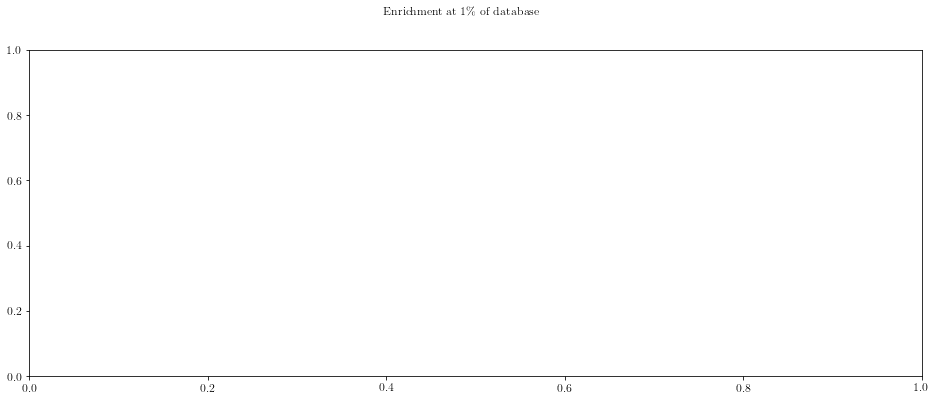

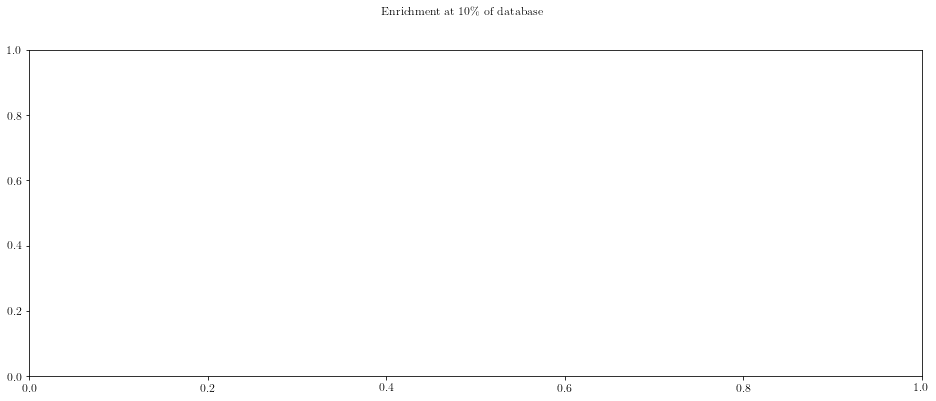

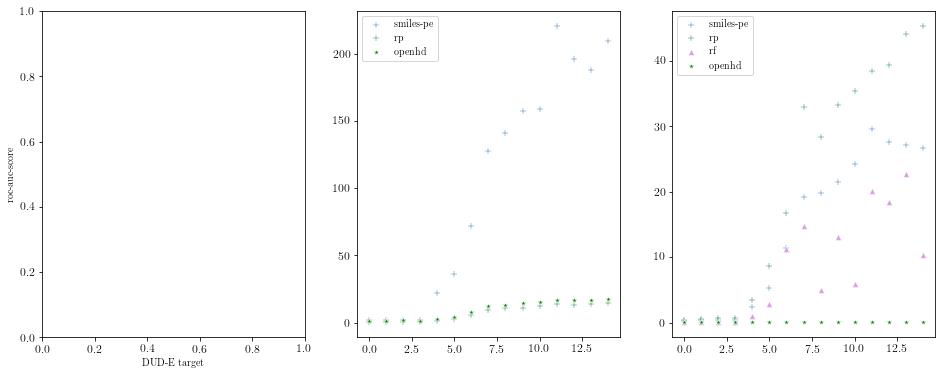

In [8]:
lit_pcba_f, lit_pcba_ax, lit_pcba_enrich_1_f, lit_pcba_enrich_1_ax, lit_pcba_enrich_10_f, lit_pcba_enrich_10_ax, model_metric_dict = aggregate_lit_pcba_results(dataset="lit_pcba", split="random_strat_split")
# plt.savefig('dude-results-all.png', dpi=600)


# for model, metric_dist in model_metric_dict.items():

In [9]:
model_metric_dict

{'smiles-pe': [(0.0, array([0.]), array([0.])),
  (0.0011160714285714285, array([1.17135847]), array([0.91502726])),
  (0.0, array([0.]), array([0.])),
  (0.0, array([3.73668639]), array([0.76499091])),
  (0.0, array([0.]), array([0.86949679])),
  (0.0, array([0.]), array([1.19039582])),
  (0.0, array([0.]), array([0.])),
  (0.0, array([4.08097735]), array([1.22443362])),
  (0.0, array([1.29335854]), array([0.5193155])),
  (0.0, array([0.]), array([0.8331318])),
  (0.0, array([0.]), array([0.])),
  (0.0, array([0.]), array([0.29196131])),
  (0.0, array([13.36734694]), array([4.28571429])),
  (0.1, array([24.13636364]), array([3.97009346])),
  (0.0, array([0.90465236]), array([0.95020491]))],
 'rp': [(0.0, array([0.]), array([2.49984001])),
  (0.03627232142857143, array([4.79699183]), array([2.37125967])),
  (0.0, array([0.]), array([0.])),
  (0.15384615384615385, array([18.68343195]), array([4.20745003])),
  (0.0, array([0.]), array([2.28242906])),
  (0.0, array([2.37950646]), array([1

In [10]:
# import pdb 
# pdb.set_trace()

model_metric_df = pd.DataFrame(model_metric_dict)
model_metric_df_list = [pd.DataFrame({"metric": [tup[0] for tup in model_metric_df[col].values], 
                                      "enrich-1": [tup[1] for tup in model_metric_df[col].values],
                                      "enrich-10": [tup[2] for tup in model_metric_df[col].values],
                                      "model": [col]*len(model_metric_df)}) for col in model_metric_df.columns]

model_metric_df = pd.concat(model_metric_df_list)
model_metric_df

,metric,enrich-1,enrich-10,model
0,0.000000,[0.0],[0.0],smiles-pe
1,0.001116,[1.17135847107438],[0.9150272605597763],smiles-pe
2,0.000000,[0.0],[0.0],smiles-pe
3,0.000000,[3.7366863905325447],[0.7649909145972139],smiles-pe
4,0.000000,[0.0],[0.8694967861768946],smiles-pe
5,0.000000,[0.0],[1.1903958180625747],smiles-pe
6,0.000000,[0.0],[0.0],smiles-pe
7,0.000000,[4.080977345066467],[1.2244336202195065],smiles-pe
8,0.000000,[1.2933585401939833],[0.5193155002557798],smiles-pe
9,0.000000,[0.0],[0.8331318016928657],smiles-pe


In [11]:
model_metric_df['enrich-1'] = model_metric_df['enrich-1'].apply(lambda x: float(np.array(x)))
model_metric_df['enrich-10'] = model_metric_df['enrich-10'].apply(lambda x: float(np.array(x)))

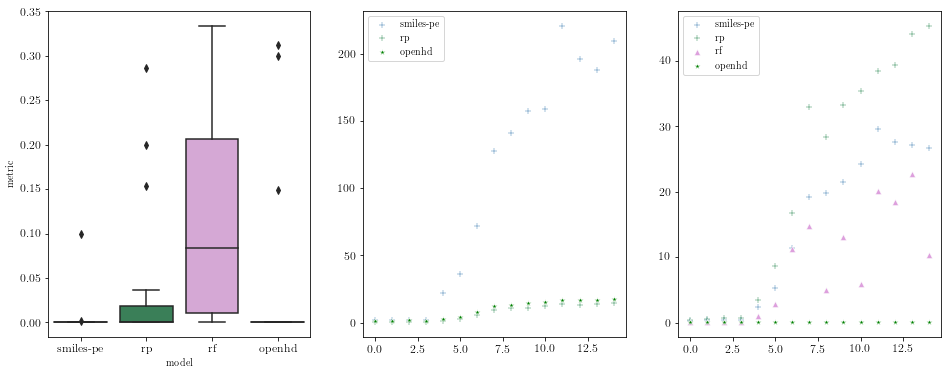

In [12]:
sns.boxplot(data=model_metric_df, x="model", y="metric", ax=lit_pcba_ax[0], palette=color_dict)
lit_pcba_f

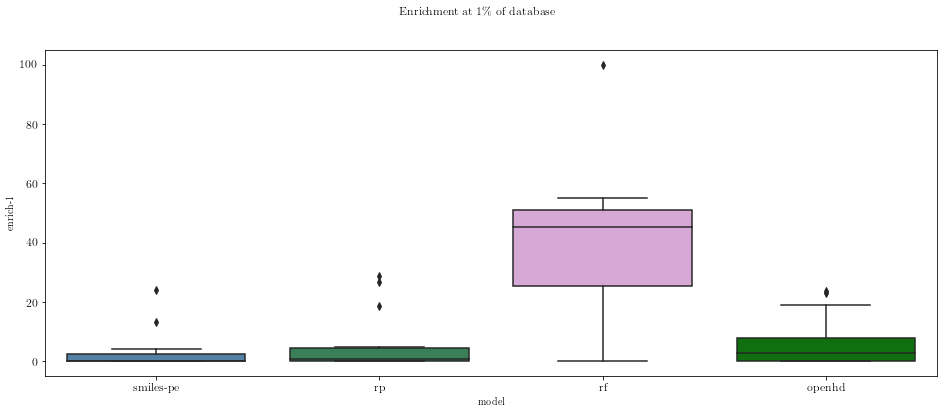

In [13]:
sns.boxplot(data=model_metric_df, x="model", y="enrich-1", ax=lit_pcba_enrich_1_ax, palette=color_dict)
lit_pcba_enrich_1_ax.set_yscale("linear")
lit_pcba_enrich_1_f

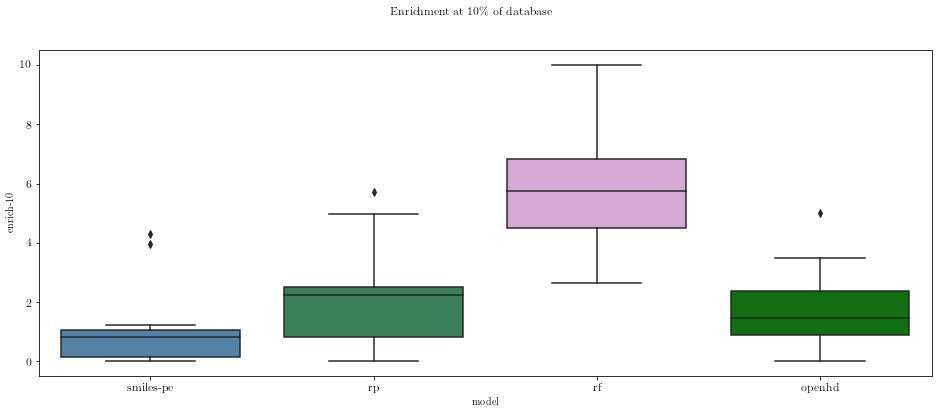

In [14]:
sns.boxplot(data=model_metric_df, x="model", y="enrich-10", ax=lit_pcba_enrich_10_ax, palette=color_dict)
lit_pcba_enrich_10_f

# LIT-PCBA AVE-split

here we use the splits provided by the authors in order to test our method on a challenging benchmark

In [15]:
lit_pcba_ave_path_list = [x for x in list(data_p.glob("lit_pcba_ave*.pkl"))]
lit_pcba_ave_path_list 

[PosixPath('/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba_ave_ADRB2.openhd.pkl'),
 PosixPath('/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba_ave_ALDH1.openhd.pkl'),
 PosixPath('/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba_ave_ESR1_ago.openhd.pkl'),
 PosixPath('/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba_ave_ESR1_ant.openhd.pkl'),
 PosixPath('/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba_ave_FEN1.openhd.pkl'),
 PosixPath('/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba_ave_IDH1.openhd.pkl'),
 PosixPath('/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba_ave_KAT2A.openhd.pkl'),
 PosixPath('/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba_ave_MAPK1.openhd.pkl'),
 PosixPath('/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba_ave_MTORC1.openhd.pkl'),
 PosixPath('/g/g13/jones289/workspace/hd-cuda-master/hdpy/h

In [16]:
def aggregate_lit_pcba_ave_results(dataset, split=None):
    
    model_metric_dict = {}
    
    
    enrich_1_f, enrich_1_ax = plt.subplots(1,1, figsize=(16,6))
    enrich_10_f, enrich_10_ax = plt.subplots(1,1, figsize=(16,6))

    
    enrich_1_f.suptitle("Enrichment at 1\% of database")
    enrich_10_f.suptitle("Enrichment at 10\% of database")
    
    f, ax = plt.subplots(1,3, figsize=(16,6))
    ax = ax.flatten()

    for model, color in color_dict.items():
        
        marker = marker_dict[model]
#         color, marker = model_tup
        
        model_metric_dict[model] = []
        
        metric_list = []
        encode_time_list = []
        train_time_list = []
        test_time_list = []
        eta_list = []
        
#         import pdb
#         pdb.set_trace()
        data_path_list = None
        if split is not None:
            data_path_list = list(data_p.glob(f"{dataset}*_{split}.{model}.pkl"))
        
        else:
            data_path_list = list(data_p.glob(f"{dataset}*{model}.pkl"))
        
        
        train_size_list = []
        test_size_list = []
        target_size_list = []
        
        
        enrich_1_list = []
        enrich_10_list = []
        
        for path in data_path_list:
            
            target = path.stem.split("_")[1]
            split = path.stem.split(".")[0].split("_")[-1]
            
            y_true, y_pred, eta, m, encode_time, train_time, test_time, train_size, test_size = load_pkl(path, model=model, return_sizes=True)
            
            if m is None:
                pass
            else:
                metric_list.append(m)
                encode_time_list.append(encode_time)
                train_time_list.append(train_time/10) # because i retrained 10 times
                test_time_list.append(test_time)
                eta_list.append(eta)
                train_size_list.append(train_size)
                test_size_list.append(test_size)
                
                enrich_1 = compute_enrichment_factor(scores=eta, labels=y_true, n_percent=.01)
                enrich_1_list.append(enrich_1)
                
                enrich_10 = compute_enrichment_factor(scores=eta, labels=y_true, n_percent=.1)
                enrich_10_list.append(enrich_10)

                target_size_list.append(train_size+test_size)
                
                model_metric_dict[model].append((m, enrich_1, enrich_10))
                
        sorted_metric_list = [x for _, x in sorted(zip(target_size_list, metric_list), key=lambda pair: pair[0])]
        sorted_encode_time_list = [x for _, x in sorted(zip(target_size_list, encode_time_list), key=lambda pair: pair[0])]
        sorted_train_time_list = [x for _, x in sorted(zip(target_size_list, train_time_list), key=lambda pair: pair[0])]
        sorted_test_time_list = [x for _, x in sorted(zip(target_size_list, test_time_list), key=lambda pair: pair[0])]
        sorted_enrich_1_list = [x for _, x in sorted(zip(target_size_list, enrich_1_list), key=lambda pair: pair[0])]
        sorted_enrich_10_list = [x for _, x in sorted(zip(target_size_list, enrich_10_list), key=lambda pair: pair[0])]
        sorted_train_size_list = sorted(train_size_list)
                
        if model not in ["rf", "mlp"]:
            sns.scatterplot(x=[x for x in range(len(target_size_list))], y=sorted_encode_time_list, ax=ax[1], color=color, marker=marker, label=model)
        sns.scatterplot(x=[x for x in range(len(target_size_list))], y=sorted_train_time_list, ax=ax[2], color=color, marker=marker, label=model)


    ax[0].set_ylabel("roc-auc-score")
    ax[0].set_xlabel("DUD-E target")

    plt.legend()
    return f, ax, enrich_1_f, enrich_1_ax, enrich_10_f, enrich_10_ax, model_metric_dict

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba_ave_ADRB2.openhd.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba_ave_ALDH1.openhd.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba_ave_ESR1_ago.openhd.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba_ave_ESR1_ant.openhd.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba_ave_FEN1.openhd.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba_ave_IDH1.openhd.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba_ave_KAT2A.openhd.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba_ave_MAPK1.openhd.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba_ave_MTORC1.openhd.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba_ave_OPRK1.openhd.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba_ave_PKM2.openhd.pkl
/g/g13/jones289/w

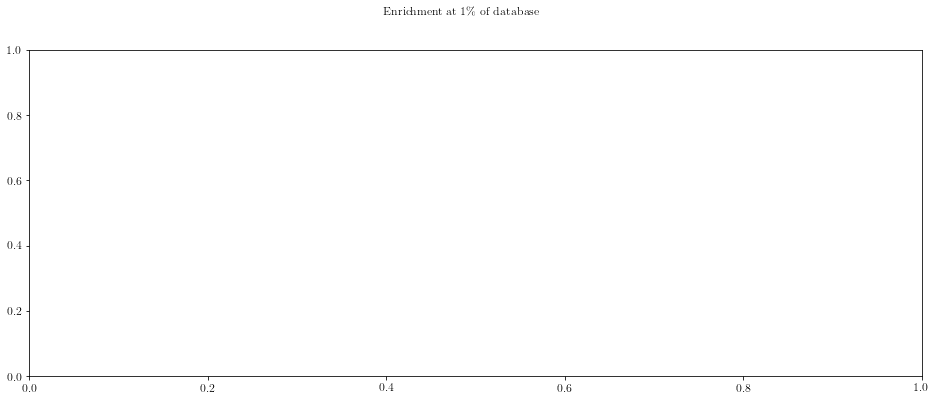

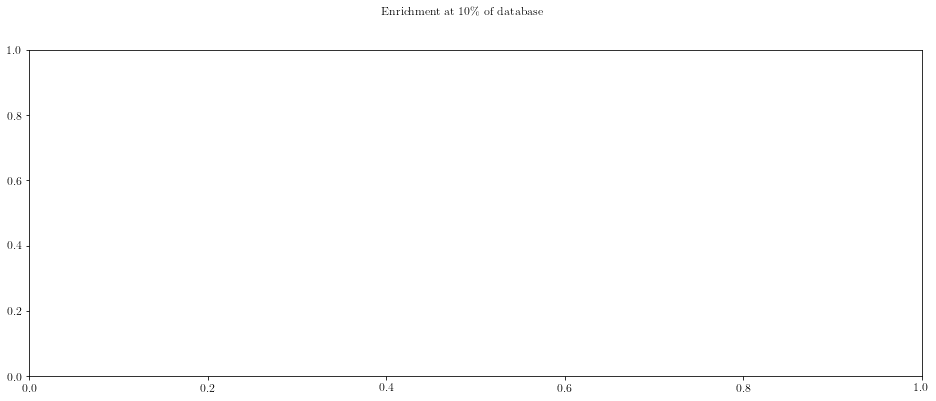

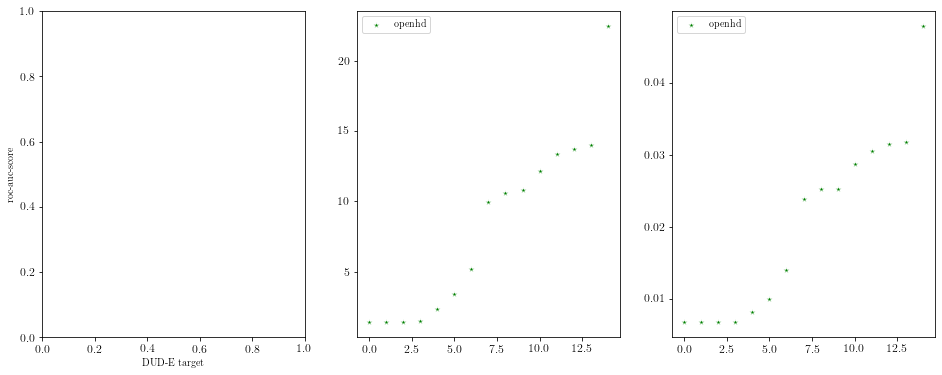

In [17]:
lit_pcba_ave_f, lit_pcba_ave_ax, lit_pcba_ave_enrich_1_f, lit_pcba_ave_enrich_1_ax, lit_pcba_ave_enrich_10_f, lit_pcba_ave_enrich_10_ax, lit_pcba_ave_model_metric_dict = aggregate_lit_pcba_ave_results(dataset="lit_pcba_ave")


In [21]:
# lit_pcba_ave_model_metric_dict = {key: value for key, value in lit_pcba_ave_model_metric_dict.items() if key not in ['smiles-pe', 'rp', 'rf']}
lit_pcba_ave_model_metric_dict = {key: value for key, value in lit_pcba_ave_model_metric_dict.items() if key not in ['smiles-pe', 'rf']}
lit_pcba_ave_model_metric_dict
lit_pcba_ave_model_metric_df = pd.DataFrame(lit_pcba_ave_model_metric_dict)
lit_pcba_ave_model_metric_df.columns
lit_pcba_ave_model_metric_df_list = [pd.DataFrame({"metric": [tup[0] for tup in lit_pcba_ave_model_metric_df[col].values],
                                      "enrich-1": [tup[1] for tup in lit_pcba_ave_model_metric_df[col].values],
                                      "enrich-10": [tup[2] for tup in lit_pcba_ave_model_metric_df[col].values],
                                      "model": [col]*len(lit_pcba_ave_model_metric_df)}) for col in lit_pcba_ave_model_metric_df.columns]

lit_pcba_ave_model_metric_df = pd.concat(lit_pcba_ave_model_metric_df_list)
lit_pcba_ave_model_metric_df

,metric,enrich-1,enrich-10,model
0,0.000000,0.238432,0.644342,openhd
1,0.000000,0.384856,0.733375,openhd
2,0.000000,12.482143,2.496429,openhd
3,0.000000,0.000000,2.839145,openhd
4,0.000000,0.000000,0.482272,openhd
5,0.000000,0.855784,0.460340,openhd
6,0.000000,0.218303,0.556737,openhd
7,0.000000,0.000000,0.331000,openhd
8,0.696203,74.386610,8.224863,openhd
9,0.000000,0.434525,0.594203,openhd


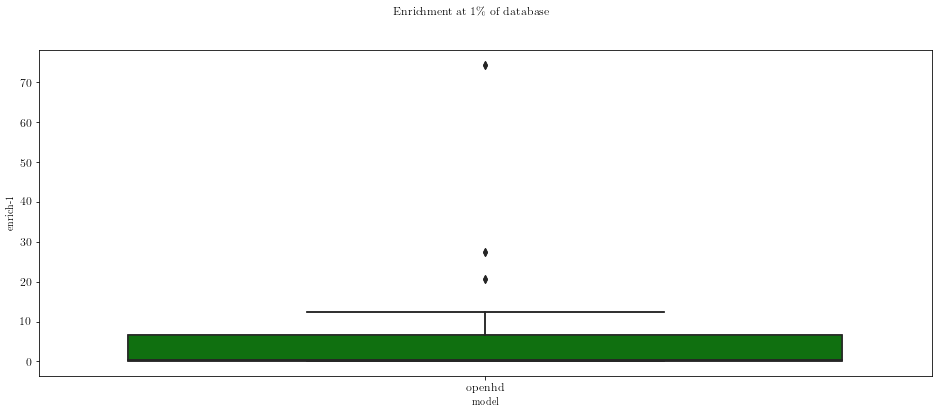

In [22]:
sns.boxplot(data=lit_pcba_ave_model_metric_df, x="model", y="enrich-1", ax=lit_pcba_ave_enrich_1_ax, palette=color_dict)
lit_pcba_ave_enrich_1_f

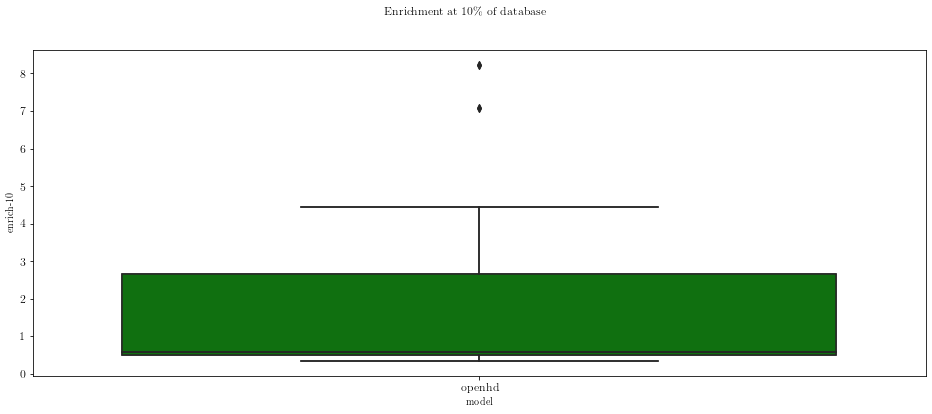

In [23]:
sns.boxplot(data=lit_pcba_ave_model_metric_df, x="model", y="enrich-10", ax=lit_pcba_ave_enrich_10_ax, palette=color_dict)
lit_pcba_ave_enrich_10_f